In [12]:
#coding:utf-8
'''
Gabor Filter 原理与实现
参考：https://blog.csdn.net/xingchenbingbuyu/article/details/79170646
'''
from __future__ import print_function
%matplotlib inline
import numpy as np
import cv2 as cv
from multiprocessing.pool import ThreadPool
import matplotlib.pyplot as plt

In [13]:
'''
ksize：返回的滤波器的大小，即Gabor核的大小。如果ksize=(a，b)，那么Gabor核的大小即为axb像素。与许多其他的卷积核一样，这个尺寸一般取奇数而且为正方形。

sigma：σ是Gabor过滤器中实用的高斯函数的标准差。

theta：θ是Gabor函数的平行条纹的法线方向。有效值为从0~360度的实数。

lambda：λ是上述方程中正弦因子的波长。有效值应大于2，以像素为单位。

gamma：γ是空间宽高比，表示Gabor滤波器的椭圆度

psi：ψ是相位偏移。有效值为-180度~180度，0度和180度对应的方程与原点对称，-90度和90度的方程分别于原点成中心对称，可两项直角坐标系中的余弦函数。
'''
def gabor_fn(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # ------这部分内容是为了确定卷积核的大小------
    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
    # ------这部分内容是为了确定卷积核的大小------

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    # ------这部分正是上面的公式（1）------
    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

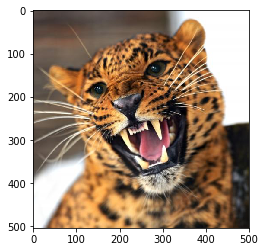

In [14]:
# 创建滤波器（们）
def build_filters():
    filters = []
    ksize = 31
    # 此处创建16个滤波器，只有getGaborKernel的第三个参数theta不同。
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

# 单线程处理
def process(img, filters):
    # zeros_like：返回和输入大小相同，类型相同，用0填满的数组
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        # maximum：逐位比较取其大
        np.maximum(accum, fimg, accum)
    return accum

# 多线程处理，threadn = 8
def process_threaded(img, filters, threadn = 8):
    accum = np.zeros_like(img)
    def f(kern):
        return cv2.filter2D(img, cv.CV_8UC3, kern)
    pool = ThreadPool(processes=threadn)
    for fimg in pool.imap_unordered(f, filters):
        np.maximum(accum, fimg, accum)
    return accum

if __name__ == '__main__':
    import sys
    #from common import Timer

    # 输出文件开头由''' '''包含的注释内容
#     print(__doc__)

#     try:
#         img_fn = sys.argv[1]
#     except:
    img_fn = 'datas/animal.jpg'

    img = cv2.imread(img_fn)
    # 判断图片是否读取成功
    if img is None:
        print('Failed to load image file:', img_fn)
        sys.exit(1)

    filters = build_filters()

    #with Timer('running single-threaded'):
    #    res1 = process(img, filters)
    #with Timer('running multi-threaded'):
    res2 = process_threaded(img, filters)

    #print('res1 == res2: ', (res1 == res2).all())
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#     cv.imshow('img', img)
#     cv.imshow('result', res2)
#     cv.waitKey()
#     cv.destroyAllWindows()

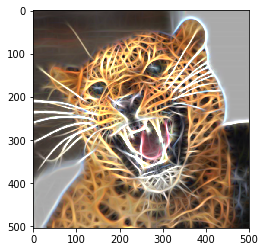

In [16]:
plt.imshow(cv2.cvtColor(res2,cv2.COLOR_BGR2RGB))